In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from scipy.signal import detrend
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

sns.set(rc={'figure.figsize':(15,8)})
sns.set_style("whitegrid")

df = pd.read_csv('cultivable_pca.csv')
df['Date'] = pd.to_datetime(df['Date'])

features = df.iloc[:, 13:]
cols = features.columns.tolist()


multitask = [40, 36, 25, 52, 1]

ds = df[[cols[i] for i in multitask] + df.filter(regex='anomalia').columns.tolist()]

#ds

In [2]:
for col in df.filter(regex='anomalia').columns.tolist():
    ds[col] = detrend(ds[col])

In [3]:
ds[ds.filter(regex='anomalia').columns.tolist()] = ds[ds.filter(regex='anomalia').columns.tolist()].apply(lambda x: x.shift(1))

In [4]:
columns = ds.columns.tolist()
for col in columns[:5]:
    for i in range(1,24):
        ds[col+'_t-'+str(i)] = ds[col].shift(i)

ds = ds.iloc[25:].reset_index(drop=True)

In [5]:
pcs = ds.filter(regex='PC')
anomalia = ds.filter(regex='anomalia')
ds = ds[pcs.columns.tolist() + anomalia.columns.tolist()]

In [6]:
#ds = ds.iloc[25:].reset_index(drop=True) # per equipararlo al caso del single task

# divide into train/val/test sets
train = ds.iloc[0:int(len(ds)*0.6)]
validation = ds.iloc[int(len(ds)*0.6):int(len(ds)*0.8)]
test = ds.iloc[int(len(ds)*0.8):]

scaler = StandardScaler()
scaler.fit(train)
ds[ds.columns] = scaler.transform(ds[ds.columns])

# update train/val/test sets
train = ds.iloc[0:int(len(ds)*0.6)]
validation = ds.iloc[int(len(ds)*0.6):int(len(ds)*0.8)]
test = ds.iloc[int(len(ds)*0.8):]

In [7]:
def plot_conmat(true, pred, ax, title, return_df=False):
    conmat = confusion_matrix(true, pred)
    val = np.mat(conmat) 

    classnames = ['Normal', 'Good', 'Bad']

    df_cm = pd.DataFrame(
        val, index=classnames, columns=classnames, 
        )
    
    #df_cm = df_cm.astype('float') / df_cm.sum(axis=1) 
    heatmap = sns.heatmap(df_cm, annot=True, ax=ax, cmap="Blues")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')

    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')

    ax.set_ylabel('True label')

    ax.set_xlabel('Predicted label')

    ax.set_title(title)

    if return_df : return df_cm



In [8]:
def annot_heatmap(df,ax):
    group_counts = ["Count: {0:0.0f}".format(value) for value in
                df.to_numpy().flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                      (df/df.sum(axis=1)[:, np.newaxis]).values.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(3,3)
    sns.heatmap(df, annot=labels, fmt='', cmap='Blues', ax=ax)

In [9]:
cols = train.iloc[:, -10:].columns.tolist()

for col in cols:
    y_min = train[col].quantile(0.33)
    y_max = train[col].quantile(0.66)
    
    train[col+'_label']= train[col].apply(lambda x: 1 if x>y_max else 2 if x<y_min else 0)
    validation[col+'_label'] = validation[col].apply(lambda x: 1 if x>y_max else 2 if x<y_min else 0)
    test[col+'_label'] = test[col].apply(lambda x: 1 if x>y_max else 2 if x<y_min else 0)

In [10]:
X_train = train.iloc[:, :120].values
X_validation = validation.iloc[:, :120].values
X_test = test.iloc[:, :120].values

y_train = train.iloc[:, 130:].values
y_validation = validation.iloc[:, 130:].values
y_test = test.iloc[:, 130:].values

In [11]:
input_ = tf.keras.layers.Input(shape=(120,), name='input')

dense_h = tf.keras.layers.Dense(128, name='dense_h')(input_)

#dense_1 = tf.keras.layers.Dense(32, name='dense_1', activation='relu')(dense_h)
#dense_2 = tf.keras.layers.Dense(32, name='dense_2', activation='relu')(dense_h)
#dense_3 = tf.keras.layers.Dense(32, name='dense_3', activation='relu')(dense_h)
#dense_4 = tf.keras.layers.Dense(32, name='dense_4', activation='relu')(dense_h)
#dense_5 = tf.keras.layers.Dense(32, name='dense_5', activation='relu')(dense_h)
#dense_6 = tf.keras.layers.Dense(32, name='dense_6', activation='relu')(dense_h)
#dense_7 = tf.keras.layers.Dense(32, name='dense_7', activation='relu')(dense_h)
#dense_8 = tf.keras.layers.Dense(32, name='dense_8', activation='relu')(dense_h)
#dense_9 = tf.keras.layers.Dense(32, name='dense_9', activation='relu')(dense_h)
#dense_10 = tf.keras.layers.Dense(32, name='dense_10', activation='relu')(dense_h)

out_1 = tf.keras.layers.Dense(3, activation='softmax', name='out_1')(dense_h)
out_2 = tf.keras.layers.Dense(3, activation='softmax', name='out_2')(dense_h)
out_3 = tf.keras.layers.Dense(3, activation='softmax', name='out_3')(dense_h)
out_4 = tf.keras.layers.Dense(3, activation='softmax', name='out_4')(dense_h)
out_5 = tf.keras.layers.Dense(3, activation='softmax', name='out_5')(dense_h)
out_6 = tf.keras.layers.Dense(3, activation='softmax', name='out_6')(dense_h)
out_7 = tf.keras.layers.Dense(3, activation='softmax', name='out_7')(dense_h)
out_8 = tf.keras.layers.Dense(3, activation='softmax', name='out_8')(dense_h)
out_9 = tf.keras.layers.Dense(3, activation='softmax', name='out_9')(dense_h)
out_10 = tf.keras.layers.Dense(3, activation='softmax', name='out_10')(dense_h)

model = tf.keras.models.Model(input_, [out_1, out_2, out_3, out_4, out_5 , out_6, out_7, out_8, out_9, out_10])

model.compile(loss={
    'out_1' : 'sparse_categorical_crossentropy',
    'out_2' : 'sparse_categorical_crossentropy',
    'out_3' : 'sparse_categorical_crossentropy',
    'out_4' : 'sparse_categorical_crossentropy',
    'out_5' : 'sparse_categorical_crossentropy',
    'out_6' : 'sparse_categorical_crossentropy',
    'out_7' : 'sparse_categorical_crossentropy',
    'out_8' : 'sparse_categorical_crossentropy',
    'out_9' : 'sparse_categorical_crossentropy',
    'out_10' : 'sparse_categorical_crossentropy'
}, optimizer='adam', metrics=['accuracy'])           

In [12]:

outputs_train = [y_train[:,0],
                 y_train[:,1],
                 y_train[:,2],
                 y_train[:,3],
                 y_train[:,4],
                 y_train[:,5],
                 y_train[:,6],
                 y_train[:,7],
                 y_train[:,8],
                 y_train[:,9]]

outputs_val = [y_validation[:,0],
               y_validation[:,1],
               y_validation[:,2],
               y_validation[:,3],
               y_validation[:,4],
               y_validation[:,5],
               y_validation[:,6],
               y_validation[:,7],
               y_validation[:,8],
               y_validation[:,9]]             

outputs_test = [y_test[:,0],
               y_test[:,1],
               y_test[:,2],
               y_test[:,3],
               y_test[:,4],
               y_test[:,5],
               y_test[:,6],
               y_test[:,7],
               y_test[:,8],
               y_test[:,9]]   

In [13]:
model.fit(X_train, outputs_train, validation_data=(X_validation, outputs_val), shuffle=False, epochs=50, verbose=0, batch_size=32)
#predictions = np.asarray(model.predict(X_test))

In [14]:
train_val = pd.concat([train,validation])

outputs_train = [train_val.iloc[int(len(train_val)*0.2):, 130],
                 train_val.iloc[int(len(train_val)*0.2):, 131],
                 train_val.iloc[int(len(train_val)*0.2):, 132],
                 train_val.iloc[int(len(train_val)*0.2):, 133],
                 train_val.iloc[int(len(train_val)*0.2):, 134],
                 train_val.iloc[int(len(train_val)*0.2):, 135],
                 train_val.iloc[int(len(train_val)*0.2):, 136],
                 train_val.iloc[int(len(train_val)*0.2):, 137],
                 train_val.iloc[int(len(train_val)*0.2):, 138],
                 train_val.iloc[int(len(train_val)*0.2):, 139]]

In [15]:
model.fit(train_val.iloc[int(len(train_val)*0.2):, :120].values,outputs_train, shuffle=False, epochs=50, verbose=0)

In [16]:
predictions = np.asarray(model.predict(X_test))
from sklearn.metrics import accuracy_score

acc_1 = accuracy_score(y_test[:, 0], predictions[0].argmax(axis=1))
acc_2 = accuracy_score(y_test[:, 1], predictions[1].argmax(axis=1))
acc_3 = accuracy_score(y_test[:, 2], predictions[2].argmax(axis=1))
acc_4 = accuracy_score(y_test[:, 3], predictions[3].argmax(axis=1))
acc_5 = accuracy_score(y_test[:, 4], predictions[4].argmax(axis=1))
acc_6 = accuracy_score(y_test[:, 5], predictions[5].argmax(axis=1))
acc_7 = accuracy_score(y_test[:, 6], predictions[6].argmax(axis=1))
acc_8 = accuracy_score(y_test[:, 7], predictions[7].argmax(axis=1))
acc_9 = accuracy_score(y_test[:, 8], predictions[8].argmax(axis=1))
acc_10 = accuracy_score(y_test[:, 9], predictions[9].argmax(axis=1))

np.mean([acc_1,acc_2,acc_3,acc_4,acc_5,acc_6,acc_7,acc_8,acc_9,acc_10])

0.4487684729064039

In [17]:
acc_4

0.3793103448275862

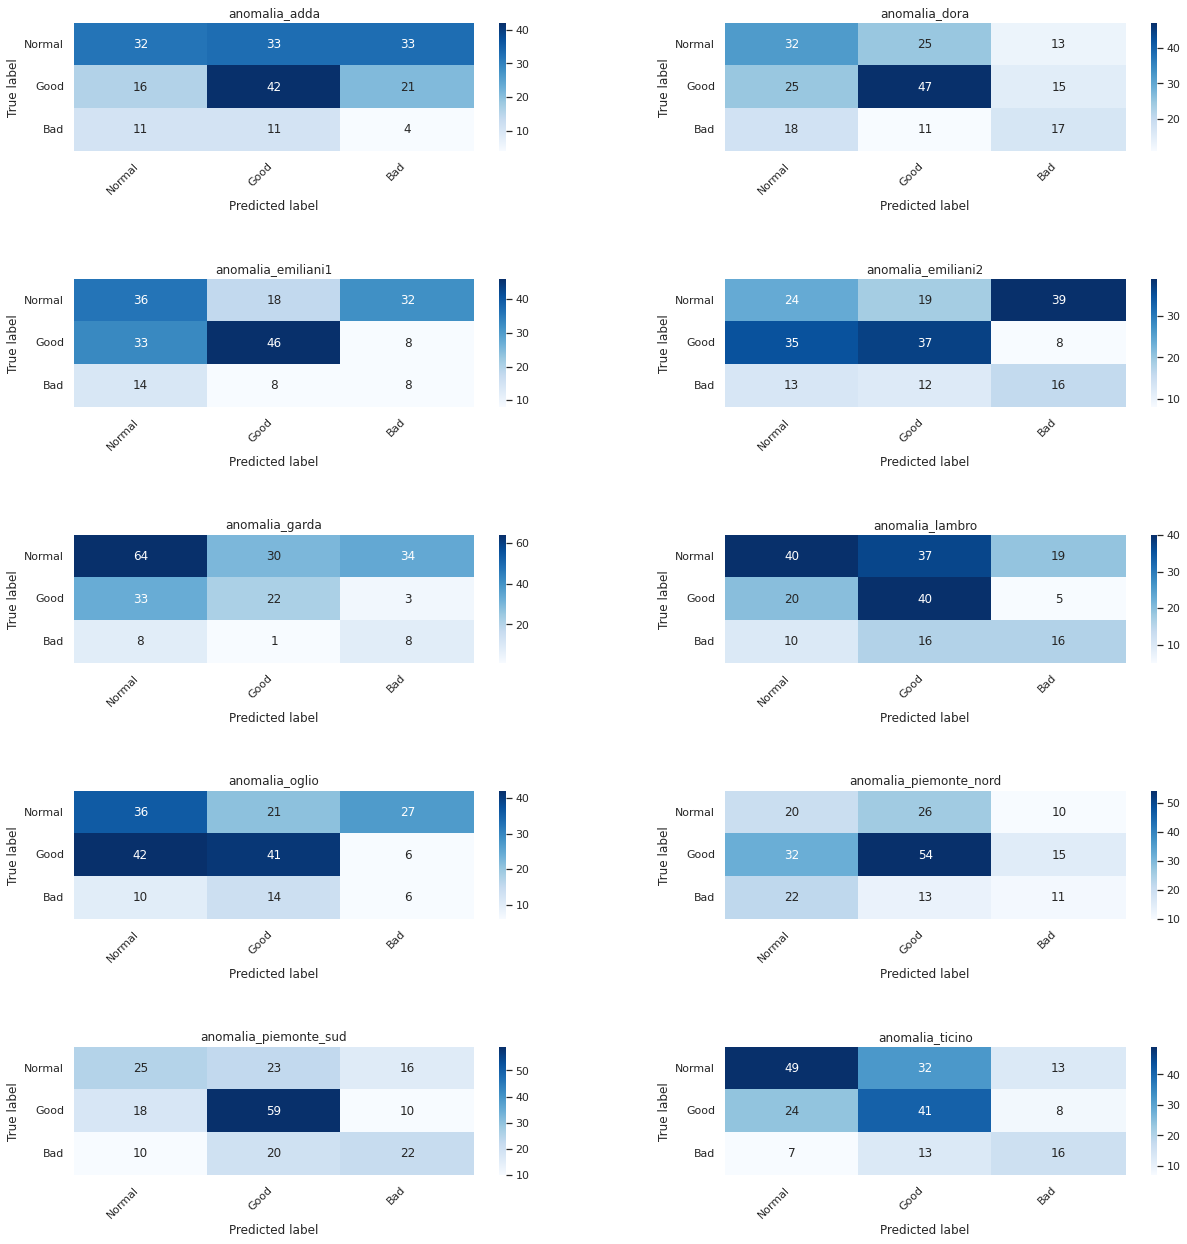

In [18]:
fig, ax = plt.subplots(5,2, figsize=(20,20))
fig.tight_layout()

df1 = plot_conmat(y_test[:, 0], predictions[0].argmax(axis=1), ax=ax[0,0], title=cols[0], return_df=True)
df2 = plot_conmat(y_test[:, 1], predictions[1].argmax(axis=1), ax=ax[0,1], title=cols[1], return_df=True)
df3 = plot_conmat(y_test[:, 2], predictions[2].argmax(axis=1), ax=ax[1,0], title=cols[2], return_df=True)
df4 = plot_conmat(y_test[:, 3], predictions[3].argmax(axis=1), ax=ax[1,1], title=cols[3], return_df=True)
df5 = plot_conmat(y_test[:, 4], predictions[4].argmax(axis=1), ax=ax[2,0], title=cols[4], return_df=True)
df6 = plot_conmat(y_test[:, 5], predictions[5].argmax(axis=1), ax=ax[2,1], title=cols[5], return_df=True)
df7 = plot_conmat(y_test[:, 6], predictions[6].argmax(axis=1), ax=ax[3,0], title=cols[6], return_df=True)
df8 = plot_conmat(y_test[:, 7], predictions[7].argmax(axis=1), ax=ax[3,1], title=cols[7], return_df=True)
df9 = plot_conmat(y_test[:, 8], predictions[8].argmax(axis=1), ax=ax[4,0], title=cols[8], return_df=True)
df10 = plot_conmat(y_test[:, 9], predictions[9].argmax(axis=1), ax=ax[4,1], title=cols[9], return_df=True)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=1)

plt.show()

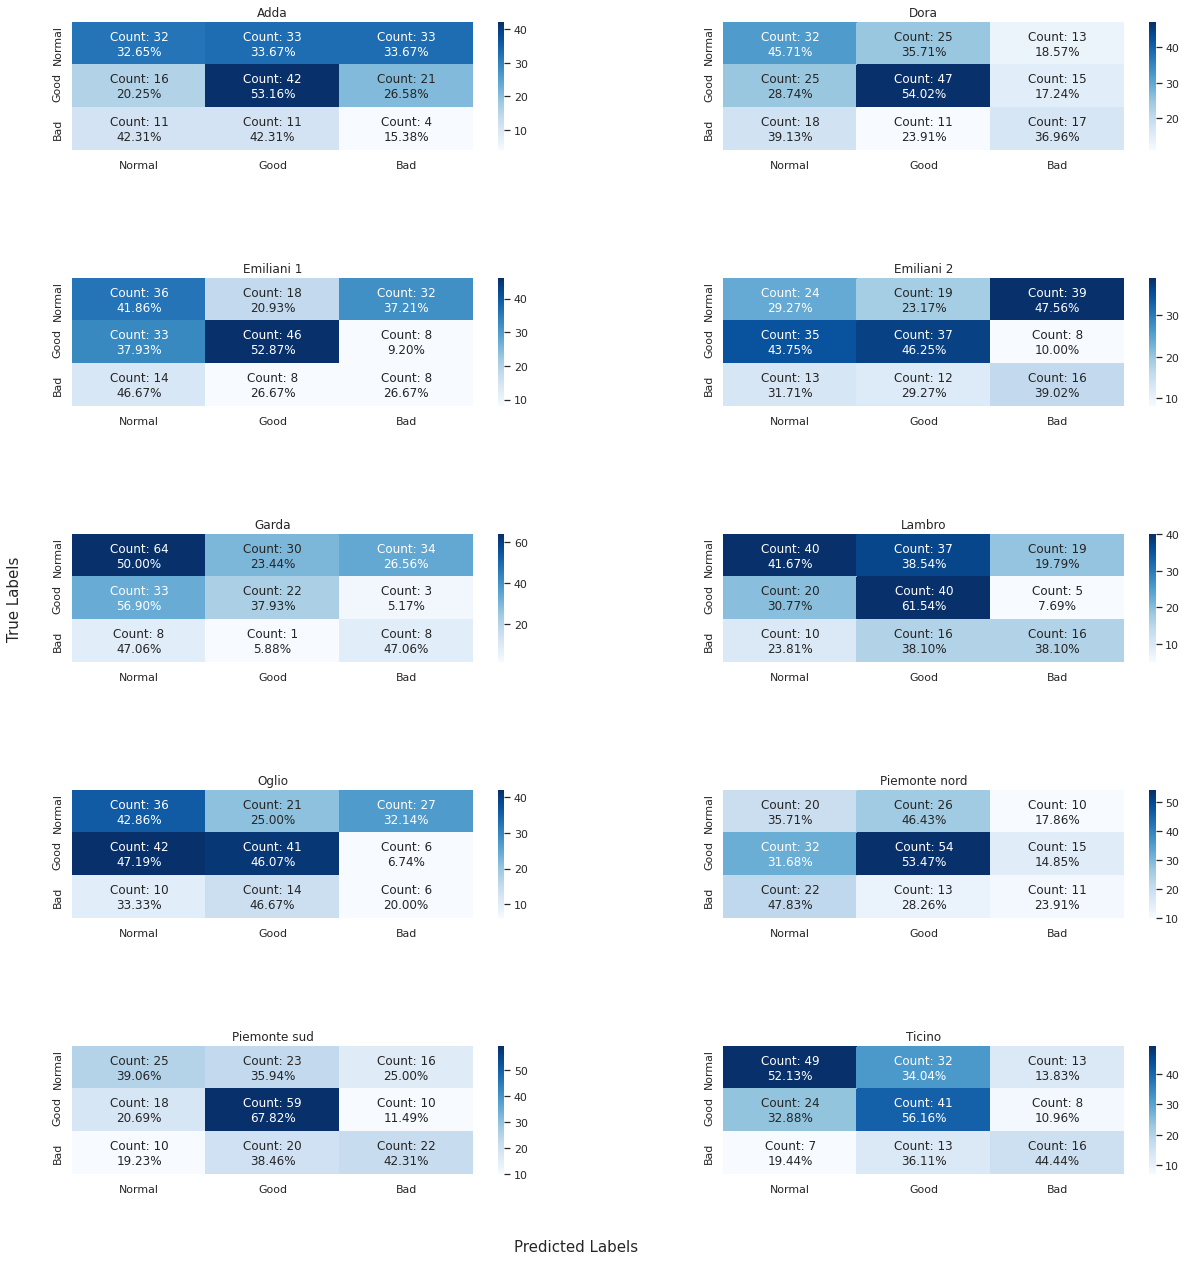

In [19]:
fig, ax = plt.subplots(5,2, figsize=(20,20))
fig.tight_layout()

annot_heatmap(df1, ax=ax[0,0])
ax[0,0].set_title('Adda')
annot_heatmap(df2, ax=ax[0,1])
ax[0,1].set_title('Dora')
annot_heatmap(df3, ax=ax[1,0])
ax[1,0].set_title('Emiliani 1')
annot_heatmap(df4, ax=ax[1,1])
ax[1,1].set_title('Emiliani 2')
annot_heatmap(df5, ax=ax[2,0])
ax[2,0].set_title('Garda')
annot_heatmap(df6, ax=ax[2,1])
ax[2,1].set_title('Lambro')
annot_heatmap(df7, ax=ax[3,0])
ax[3,0].set_title('Oglio')
annot_heatmap(df8, ax=ax[3,1])
ax[3,1].set_title('Piemonte nord')
annot_heatmap(df9, ax=ax[4,0])
ax[4,0].set_title('Piemonte sud')
annot_heatmap(df10, ax=ax[4,1])
ax[4,1].set_title('Ticino')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=1)

# Set common labels

fig.text(0.45, 0.05, 'Predicted Labels', ha='center', va='center', fontsize=15)
fig.text(0.06, 0.5, 'True Labels', ha='center', va='center', rotation='vertical', fontsize=15)

fig.savefig('imgs/multitask_feedforward.eps', format='eps')


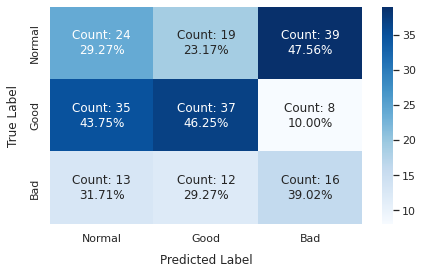

In [20]:
fig, ax = plt.subplots(figsize=(7,4))
annot_heatmap(df4, ax=ax)
ax.set_xlabel('Predicted Label', labelpad=10)
ax.set_ylabel('True Label', labelpad=10)
fig.savefig('imgs/multi_emi2_ffnn.eps', format='eps', bbox_inches='tight')

In [21]:
test_correct = list(map(lambda x: -1 if x==2 else 1 if x==1 else 0, y_test[:,3]))
pred_correct = list(map(lambda x: -1 if x==2 else 1 if x==1 else 0, predictions[3].argmax(axis=1)))

In [22]:
sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid", {'axes.grid':False})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


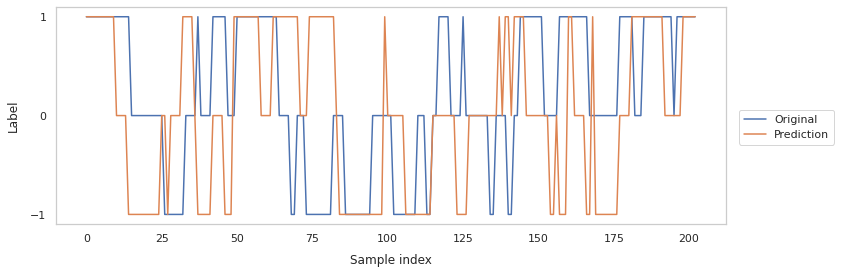

In [23]:
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

#fig,ax=plt.subplots(ù))
plt.plot(test_correct, label='Original')
plt.plot(pred_correct, label='Prediction')
plt.legend(loc='upper right', bbox_to_anchor=(1.17,0.55))
plt.xlabel('Sample index',labelpad=10)
plt.ylabel('Label', labelpad=10)
plt.savefig('imgs/curves_emi2_ffnn.eps', format='eps', bbox_inches='tight')

# Task clustering

In [24]:
X_train = train.iloc[:, :120].values
X_validation = validation.iloc[:, :120].values
X_test = test.iloc[:, :120].values

y_train = train.iloc[:, 130:].values
y_validation = validation.iloc[:, 130:].values
y_test = test.iloc[:, 130:].values

In [25]:

outputs_train = [y_train[:,0],
                 y_train[:,1],
                 y_train[:,2],
                 y_train[:,3],
                 y_train[:,4],
                 y_train[:,5],
                 y_train[:,6],
                 y_train[:,7],
                 y_train[:,8],
                 y_train[:,9]]

outputs_val = [y_validation[:,0],
               y_validation[:,1],
               y_validation[:,2],
               y_validation[:,3],
               y_validation[:,4],
               y_validation[:,5],
               y_validation[:,6],
               y_validation[:,7],
               y_validation[:,8],
               y_validation[:,9]]             

outputs_test = [y_test[:,0],
               y_test[:,1],
               y_test[:,2],
               y_test[:,3],
               y_test[:,4],
               y_test[:,5],
               y_test[:,6],
               y_test[:,7],
               y_test[:,8],
               y_test[:,9]]   

In [26]:
input_ = tf.keras.layers.Input(shape=(120,), name='input')

dense_h = tf.keras.layers.Dense(64, name='dense_h', activation='relu')(input_)

dense_1 = tf.keras.layers.Dense(64, name='dense_1', activation='relu')(dense_h)
dense_2 = tf.keras.layers.Dense(64, name='dense_2', activation='relu')(dense_h)
dense_3 = tf.keras.layers.Dense(64, name='dense_3', activation='relu')(dense_h)
dense_4 = tf.keras.layers.Dense(64, name='dense_4', activation='relu')(dense_h)

out_1 = tf.keras.layers.Dense(3, activation='softmax', name='out_1')(dense_1)
out_2 = tf.keras.layers.Dense(3, activation='softmax', name='out_2')(dense_2)
out_3 = tf.keras.layers.Dense(3, activation='softmax', name='out_3')(dense_3)
out_4 = tf.keras.layers.Dense(3, activation='softmax', name='out_4')(dense_3)
out_5 = tf.keras.layers.Dense(3, activation='softmax', name='out_5')(dense_4)
out_6 = tf.keras.layers.Dense(3, activation='softmax', name='out_6')(dense_1)
out_7 = tf.keras.layers.Dense(3, activation='softmax', name='out_7')(dense_4)
out_8 = tf.keras.layers.Dense(3, activation='softmax', name='out_8')(dense_2)
out_9 = tf.keras.layers.Dense(3, activation='softmax', name='out_9')(dense_3)
out_10 = tf.keras.layers.Dense(3, activation='softmax', name='out_10')(dense_1)

model = tf.keras.models.Model(input_, [out_1, out_2, out_3, out_4, out_5 , out_6, out_7, out_8, out_9, out_10])

model.compile(loss={
    'out_1' : 'sparse_categorical_crossentropy',
    'out_2' : 'sparse_categorical_crossentropy',
    'out_3' : 'sparse_categorical_crossentropy',
    'out_4' : 'sparse_categorical_crossentropy',
    'out_5' : 'sparse_categorical_crossentropy',
    'out_6' : 'sparse_categorical_crossentropy',
    'out_7' : 'sparse_categorical_crossentropy',
    'out_8' : 'sparse_categorical_crossentropy',
    'out_9' : 'sparse_categorical_crossentropy',
    'out_10' : 'sparse_categorical_crossentropy'
}, optimizer='adam', metrics=['accuracy'])

In [27]:
model.fit(X_train, outputs_train, validation_data=(X_validation, outputs_val), shuffle=False, epochs=70, verbose=0, batch_size=32)

In [28]:
train_val = pd.concat([train,validation])

new_outputs_train = [train_val.iloc[int(len(train_val)*0.2):, 130],
                 train_val.iloc[int(len(train_val)*0.2):, 131],
                 train_val.iloc[int(len(train_val)*0.2):, 132],
                 train_val.iloc[int(len(train_val)*0.2):, 133],
                 train_val.iloc[int(len(train_val)*0.2):, 134],
                 train_val.iloc[int(len(train_val)*0.2):, 135],
                 train_val.iloc[int(len(train_val)*0.2):, 136],
                 train_val.iloc[int(len(train_val)*0.2):, 137],
                 train_val.iloc[int(len(train_val)*0.2):, 138],
                 train_val.iloc[int(len(train_val)*0.2):, 139]]

In [29]:
model.fit(train_val.iloc[int(len(train_val)*0.2):, :120].values, new_outputs_train, shuffle=False, epochs=50, verbose=0)

predictions = np.asarray(model.predict(X_test))

acc_1 = accuracy_score(y_test[:, 0], predictions[0].argmax(axis=1))
acc_2 = accuracy_score(y_test[:, 1], predictions[1].argmax(axis=1))
acc_3 = accuracy_score(y_test[:, 2], predictions[2].argmax(axis=1))
acc_4 = accuracy_score(y_test[:, 3], predictions[3].argmax(axis=1))
acc_5 = accuracy_score(y_test[:, 4], predictions[4].argmax(axis=1))
acc_6 = accuracy_score(y_test[:, 5], predictions[5].argmax(axis=1))
acc_7 = accuracy_score(y_test[:, 6], predictions[6].argmax(axis=1))
acc_8 = accuracy_score(y_test[:, 7], predictions[7].argmax(axis=1))
acc_9 = accuracy_score(y_test[:, 8], predictions[8].argmax(axis=1))
acc_10 = accuracy_score(y_test[:, 9], predictions[9].argmax(axis=1))

np.mean([acc_1,acc_2,acc_3,acc_4,acc_5,acc_6,acc_7,acc_8,acc_9,acc_10])

0.3916256157635468

In [30]:
acc_4

0.4088669950738916

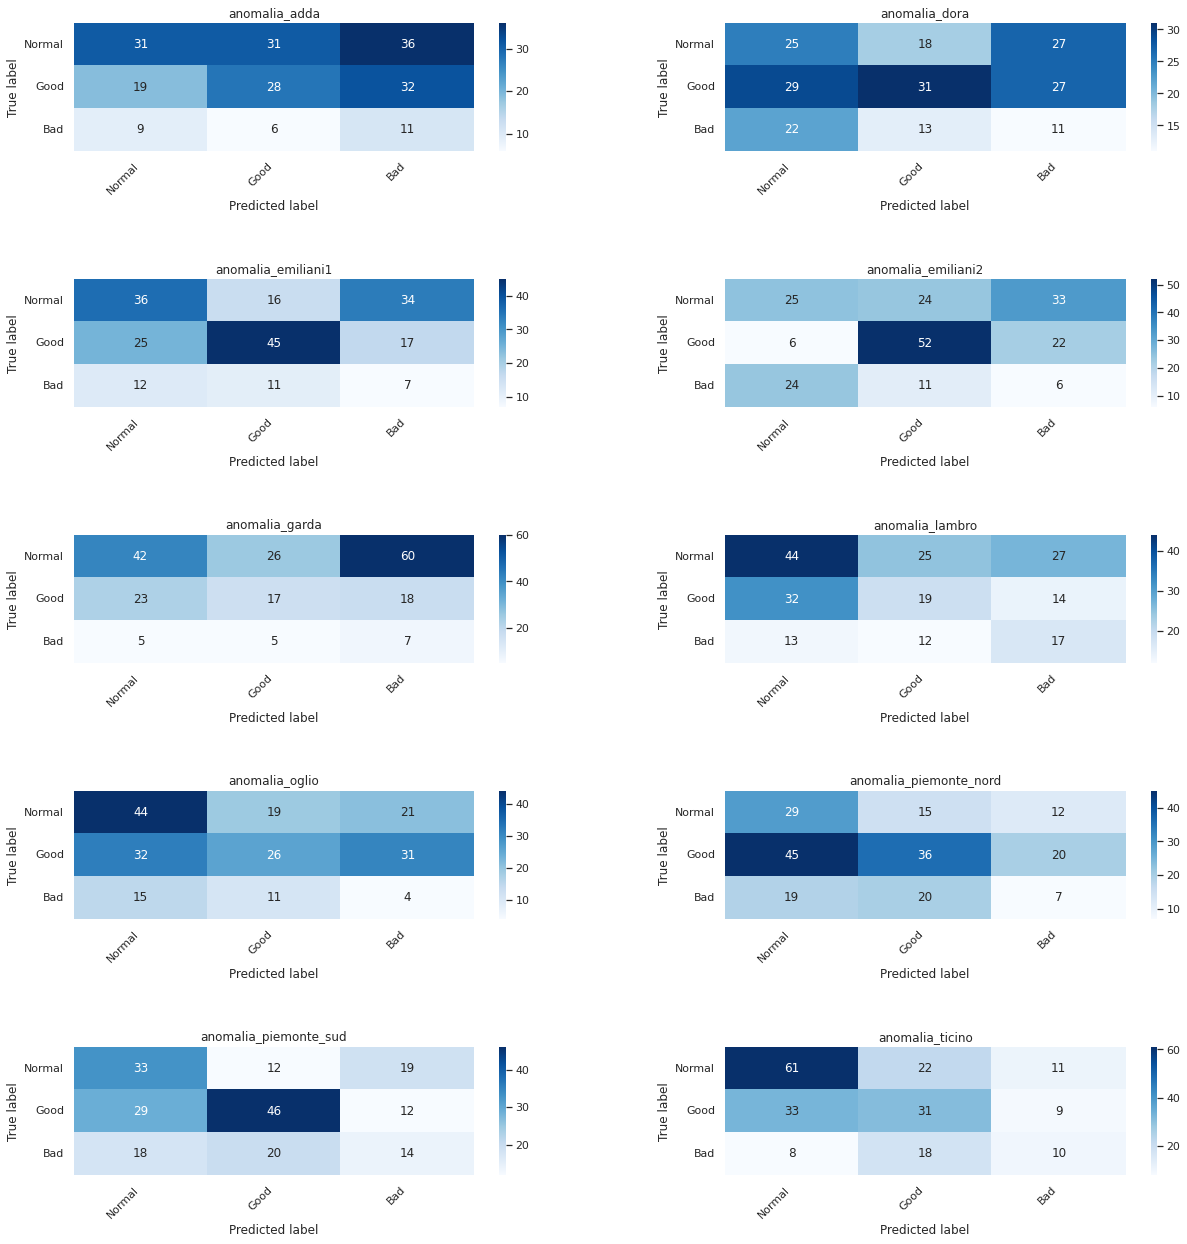

In [31]:
fig, ax = plt.subplots(5,2, figsize=(20,20))
fig.tight_layout()

df1 = plot_conmat(y_test[:, 0], predictions[0].argmax(axis=1), ax=ax[0,0], title=cols[0], return_df=True)
df2 = plot_conmat(y_test[:, 1], predictions[1].argmax(axis=1), ax=ax[0,1], title=cols[1], return_df=True)
df3 = plot_conmat(y_test[:, 2], predictions[2].argmax(axis=1), ax=ax[1,0], title=cols[2], return_df=True)
df4 = plot_conmat(y_test[:, 3], predictions[3].argmax(axis=1), ax=ax[1,1], title=cols[3], return_df=True)
df5 = plot_conmat(y_test[:, 4], predictions[4].argmax(axis=1), ax=ax[2,0], title=cols[4], return_df=True)
df6 = plot_conmat(y_test[:, 5], predictions[5].argmax(axis=1), ax=ax[2,1], title=cols[5], return_df=True)
df7 = plot_conmat(y_test[:, 6], predictions[6].argmax(axis=1), ax=ax[3,0], title=cols[6], return_df=True)
df8 = plot_conmat(y_test[:, 7], predictions[7].argmax(axis=1), ax=ax[3,1], title=cols[7], return_df=True)
df9 = plot_conmat(y_test[:, 8], predictions[8].argmax(axis=1), ax=ax[4,0], title=cols[8], return_df=True)
df10 = plot_conmat(y_test[:, 9], predictions[9].argmax(axis=1), ax=ax[4,1], title=cols[9], return_df=True)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=1)

plt.show()

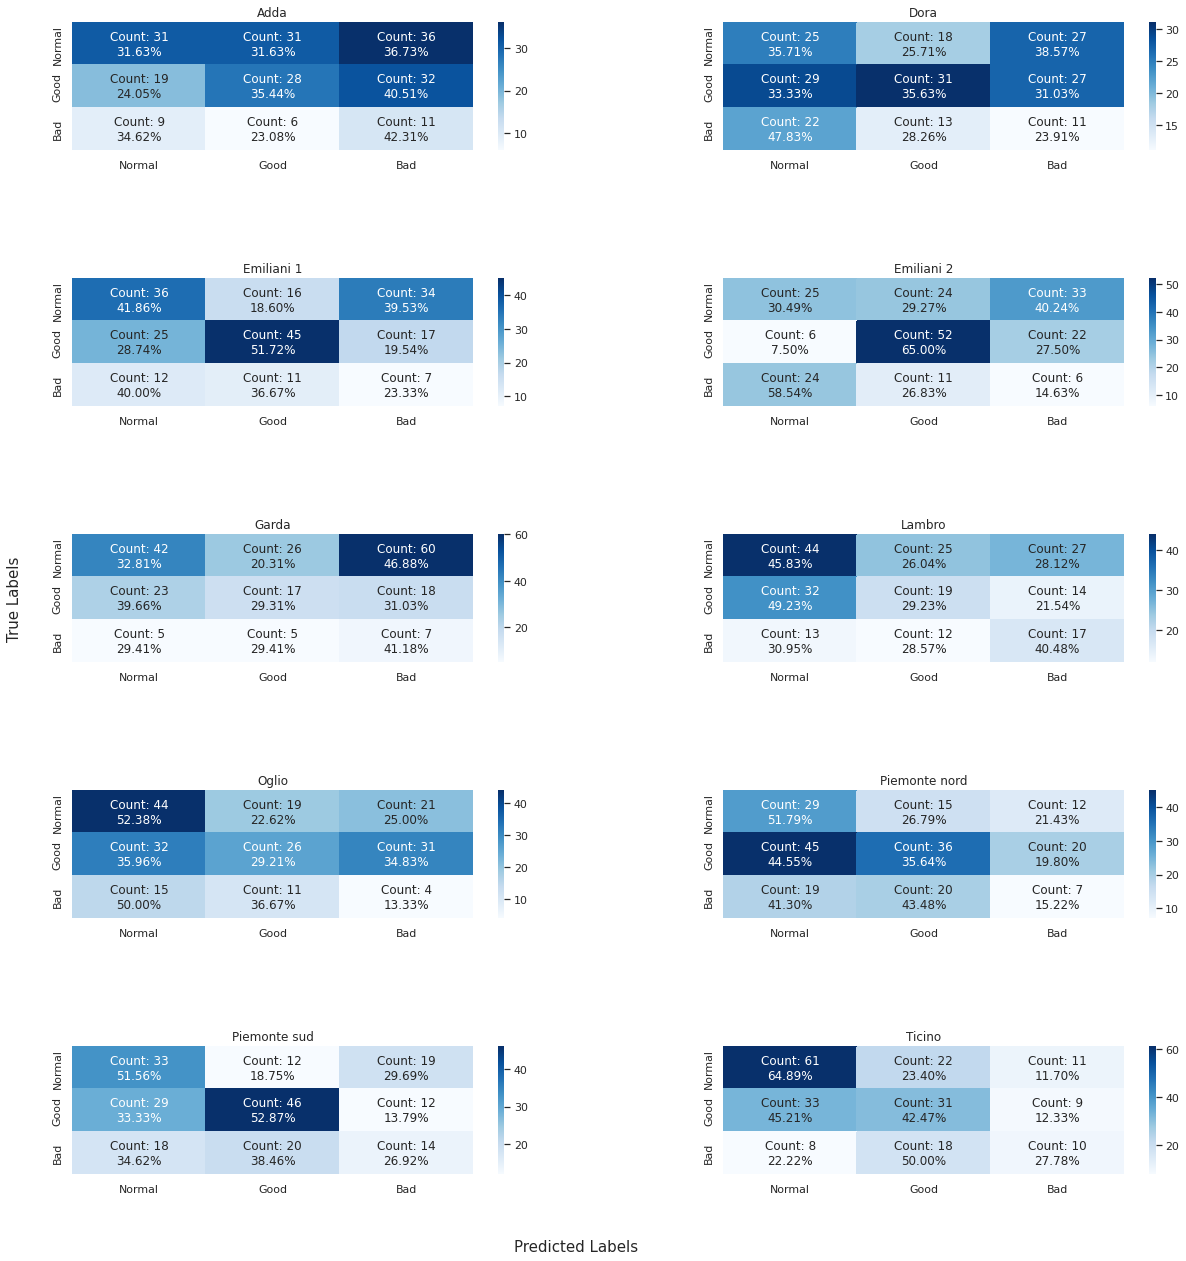

In [32]:
fig, ax = plt.subplots(5,2, figsize=(20,20))
fig.tight_layout()

annot_heatmap(df1, ax=ax[0,0])
ax[0,0].set_title('Adda')
annot_heatmap(df2, ax=ax[0,1])
ax[0,1].set_title('Dora')
annot_heatmap(df3, ax=ax[1,0])
ax[1,0].set_title('Emiliani 1')
annot_heatmap(df4, ax=ax[1,1])
ax[1,1].set_title('Emiliani 2')
annot_heatmap(df5, ax=ax[2,0])
ax[2,0].set_title('Garda')
annot_heatmap(df6, ax=ax[2,1])
ax[2,1].set_title('Lambro')
annot_heatmap(df7, ax=ax[3,0])
ax[3,0].set_title('Oglio')
annot_heatmap(df8, ax=ax[3,1])
ax[3,1].set_title('Piemonte nord')
annot_heatmap(df9, ax=ax[4,0])
ax[4,0].set_title('Piemonte sud')
annot_heatmap(df10, ax=ax[4,1])
ax[4,1].set_title('Ticino')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=1)

# Set common labels

fig.text(0.45, 0.05, 'Predicted Labels', ha='center', va='center', fontsize=15)
fig.text(0.06, 0.5, 'True Labels', ha='center', va='center', rotation='vertical', fontsize=15)

fig.savefig('imgs/multitask_taskcluster_feedforward.eps', format='eps')

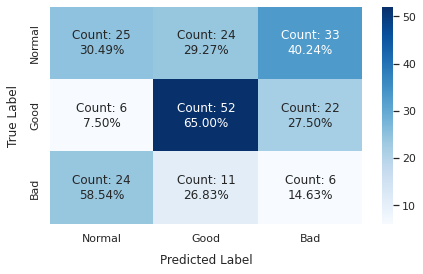

In [33]:
fig, ax = plt.subplots(figsize=(7,4))
annot_heatmap(df4, ax=ax)
ax.set_xlabel('Predicted Label', labelpad=10)
ax.set_ylabel('True Label', labelpad=10)
fig.savefig('imgs/multi_taskcluster_emi2_ffnn.eps', format='eps', bbox_inches='tight')

In [34]:
test_correct = list(map(lambda x: -1 if x==2 else 1 if x==1 else 0, y_test[:, 3]))
pred_correct = list(map(lambda x: -1 if x==2 else 1 if x==1 else 0, predictions[3].argmax(axis=1)))

In [35]:
sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid", {'axes.grid':False})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


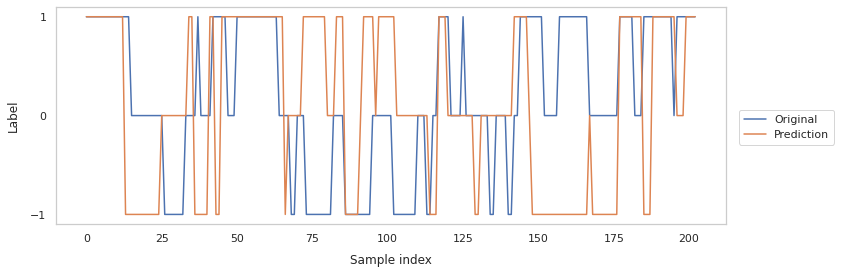

In [36]:

ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))


#fig,ax=plt.subplots(ù))
plt.plot(test_correct, label='Original')
plt.plot(pred_correct, label='Prediction')
plt.legend(loc='upper right', bbox_to_anchor=(1.17,0.55))
plt.xlabel('Sample index',labelpad=10)
plt.ylabel('Label', labelpad=10)
plt.savefig('imgs/curves_taskcluster_emi2_ffnn.eps', format='eps', bbox_inches='tight')

# Recurrent

In [59]:
X_train = train.iloc[:, :120].values
X_validation = validation.iloc[:, :120].values
X_test = test.iloc[:, :120].values

y_train = train.iloc[:, 130:].values
y_validation = validation.iloc[:, 130:].values
y_test = test.iloc[:, 130:].values

In [38]:

outputs_train = [y_train[:,0],
                 y_train[:,1],
                 y_train[:,2],
                 y_train[:,3],
                 y_train[:,4],
                 y_train[:,5],
                 y_train[:,6],
                 y_train[:,7],
                 y_train[:,8],
                 y_train[:,9]]

outputs_val = [y_validation[:,0],
               y_validation[:,1],
               y_validation[:,2],
               y_validation[:,3],
               y_validation[:,4],
               y_validation[:,5],
               y_validation[:,6],
               y_validation[:,7],
               y_validation[:,8],
               y_validation[:,9]]             

outputs_test = [y_test[:,0],
               y_test[:,1],
               y_test[:,2],
               y_test[:,3],
               y_test[:,4],
               y_test[:,5],
               y_test[:,6],
               y_test[:,7],
               y_test[:,8],
               y_test[:,9]]   

In [39]:
input_ = tf.keras.layers.Input(shape=(None, 120), name='input', batch_size=None)

rnn_1 = tf.keras.layers.SimpleRNN(10, name='rnn_1', return_sequences=True)(input_)

out_1 = tf.keras.layers.Dense(3, activation='softmax', name='out_1')(rnn_1)
out_2 = tf.keras.layers.Dense(3, activation='softmax', name='out_2')(rnn_1)
out_3 = tf.keras.layers.Dense(3, activation='softmax', name='out_3')(rnn_1)
out_4 = tf.keras.layers.Dense(3, activation='softmax', name='out_4')(rnn_1)
out_5 = tf.keras.layers.Dense(3, activation='softmax', name='out_5')(rnn_1)
out_6 = tf.keras.layers.Dense(3, activation='softmax', name='out_6')(rnn_1)
out_7 = tf.keras.layers.Dense(3, activation='softmax', name='out_7')(rnn_1)
out_8 = tf.keras.layers.Dense(3, activation='softmax', name='out_8')(rnn_1)
out_9 = tf.keras.layers.Dense(3, activation='softmax', name='out_9')(rnn_1)
out_10 = tf.keras.layers.Dense(3, activation='softmax', name='out_10')(rnn_1)

model = tf.keras.models.Model(input_, [out_1,
                                       out_2,
                                       out_3,
                                       out_4,
                                       out_5,
                                       out_6,
                                       out_7,
                                       out_8,
                                       out_9,
                                       out_10])

model.compile(loss={ 'out_1': 'sparse_categorical_crossentropy', 
                    'out_2' : 'sparse_categorical_crossentropy', 
                    'out_3' : 'sparse_categorical_crossentropy', 
                    'out_4' : 'sparse_categorical_crossentropy', 
                    'out_5' : 'sparse_categorical_crossentropy', 
                    'out_6' : 'sparse_categorical_crossentropy', 
                    'out_7' : 'sparse_categorical_crossentropy', 
                    'out_8' : 'sparse_categorical_crossentropy', 
                    'out_9' : 'sparse_categorical_crossentropy', 
                    'out_10' : 'sparse_categorical_crossentropy'},
                    optimizer='adam', metrics=['accuracy'])

In [40]:
outputs_train = [y_train[:,0].reshape(1,-1),
                 y_train[:, 1].reshape(1,-1),
                 y_train[:, 2].reshape(1,-1),
                 y_train[:, 3].reshape(1,-1),
                 y_train[:, 4].reshape(1,-1),
                 y_train[:, 5].reshape(1,-1),
                 y_train[:, 6].reshape(1,-1),
                 y_train[:, 7].reshape(1,-1),
                 y_train[:, 8].reshape(1,-1),
                 y_train[:, 9].reshape(1,-1)]

outputs_validation = [y_validation[:,0].reshape(1,-1),
                      y_validation[:, 1].reshape(1,-1),
                      y_validation[:, 2].reshape(1,-1),
                      y_validation[:, 3].reshape(1,-1),
                      y_validation[:, 4].reshape(1,-1),
                      y_validation[:, 5].reshape(1,-1),
                      y_validation[:, 6].reshape(1,-1),
                      y_validation[:, 7].reshape(1,-1),
                      y_validation[:, 8].reshape(1,-1),
                      y_validation[:, 9].reshape(1,-1)]

In [41]:
model.fit(X_train.reshape(1,607,120), outputs_train, shuffle=False, validation_data=(X_validation.reshape(1,203,120), outputs_validation), verbose=0, epochs=35, batch_size=32)

In [42]:
train_val = pd.concat([train,validation])

outputs_train = [train_val.iloc[int(len(train_val)*0.2):, 130].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 131].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 132].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 133].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 134].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 135].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 136].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 137].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 138].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 139].values.reshape(1,-1)]

X_train = train_val.iloc[int(len(train_val)*0.2):, :120].values

In [43]:
model.fit(X_train.reshape(1,648,120), outputs_train, shuffle=False, verbose=0, epochs=35, batch_size=32)

In [44]:
predictions = np.asarray(model.predict(X_test.reshape(1,203,120)))

In [45]:
predictions = predictions.reshape(10,203,3)

In [46]:
acc_1 = accuracy_score(y_test[:, 0], predictions[0, :].argmax(axis=1))
acc_2 = accuracy_score(y_test[:, 1], predictions[1, :].argmax(axis=1))
acc_3 = accuracy_score(y_test[:, 2], predictions[2, :].argmax(axis=1))
acc_4 = accuracy_score(y_test[:, 3], predictions[3, :].argmax(axis=1))
acc_5 = accuracy_score(y_test[:, 4], predictions[4, :].argmax(axis=1))
acc_6 = accuracy_score(y_test[:, 5], predictions[5, :].argmax(axis=1))
acc_7 = accuracy_score(y_test[:, 6], predictions[6, :].argmax(axis=1))
acc_8 = accuracy_score(y_test[:, 7], predictions[7, :].argmax(axis=1))
acc_9 = accuracy_score(y_test[:, 8], predictions[8, :].argmax(axis=1))
acc_10 = accuracy_score(y_test[:, 9], predictions[9, :].argmax(axis=1))

np.mean([acc_1,acc_2,acc_3,acc_4,acc_5,acc_6,acc_7,acc_8,acc_9,acc_10])

0.374384236453202

In [47]:
acc_4

0.4876847290640394

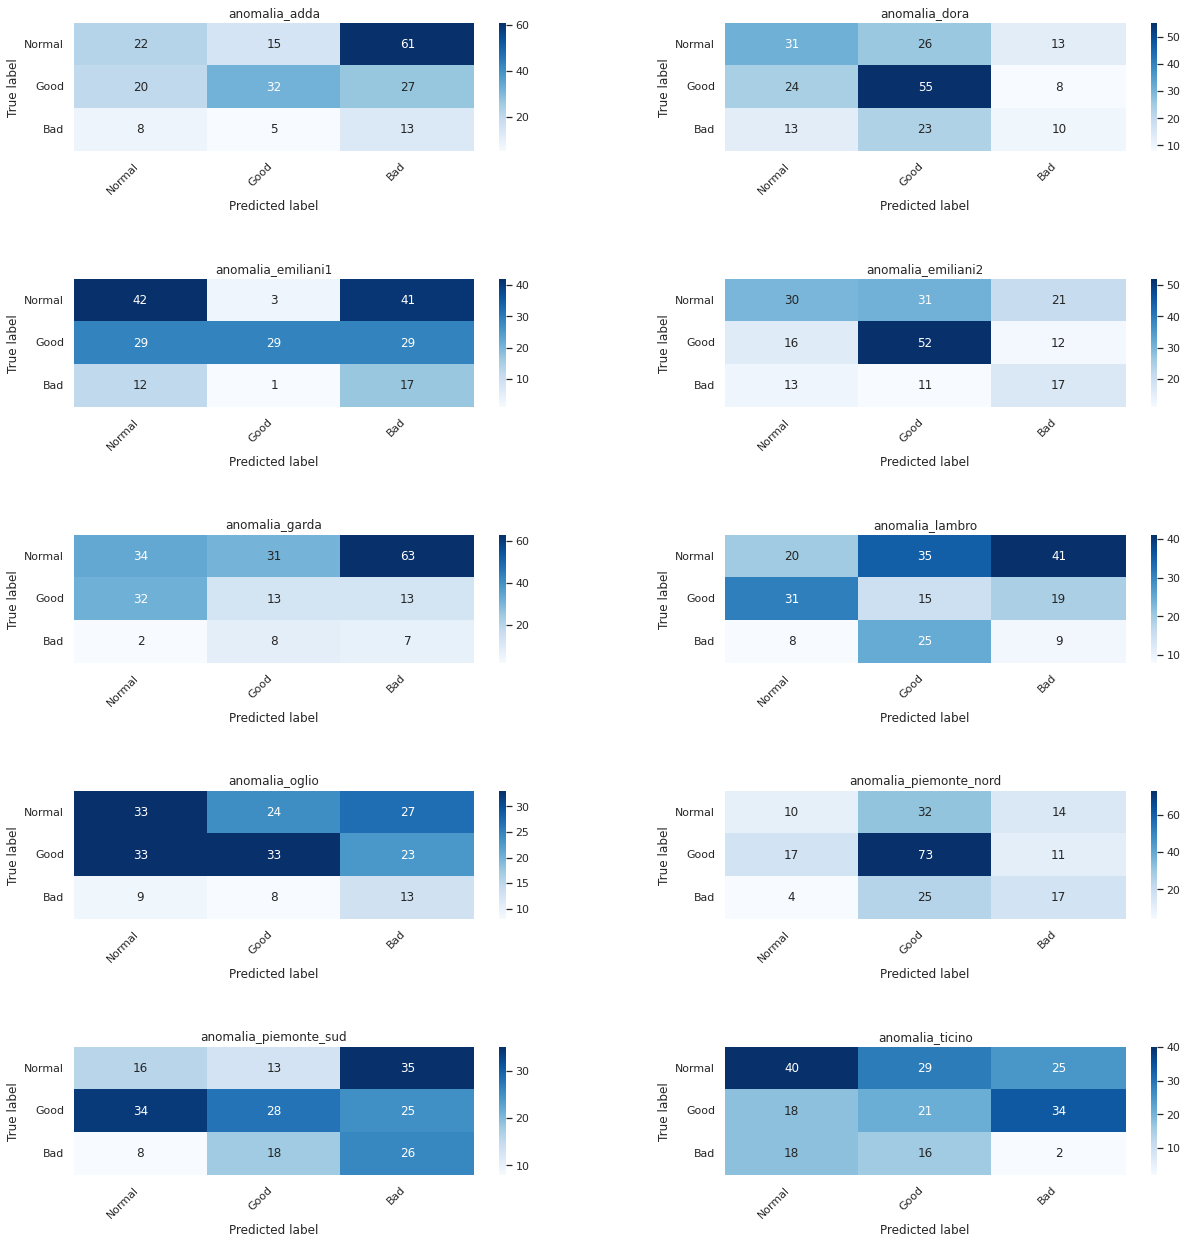

In [48]:
fig, ax = plt.subplots(5,2, figsize=(20,20))
fig.tight_layout()

df1 = plot_conmat(y_test[:, 0], predictions[0].argmax(axis=1), ax=ax[0,0], title=cols[0], return_df=True)
df2 = plot_conmat(y_test[:, 1], predictions[1].argmax(axis=1), ax=ax[0,1], title=cols[1], return_df=True)
df3 = plot_conmat(y_test[:, 2], predictions[2].argmax(axis=1), ax=ax[1,0], title=cols[2], return_df=True)
df4 = plot_conmat(y_test[:, 3], predictions[3].argmax(axis=1), ax=ax[1,1], title=cols[3], return_df=True)
df5 = plot_conmat(y_test[:, 4], predictions[4].argmax(axis=1), ax=ax[2,0], title=cols[4], return_df=True)
df6 = plot_conmat(y_test[:, 5], predictions[5].argmax(axis=1), ax=ax[2,1], title=cols[5], return_df=True)
df7 = plot_conmat(y_test[:, 6], predictions[6].argmax(axis=1), ax=ax[3,0], title=cols[6], return_df=True)
df8 = plot_conmat(y_test[:, 7], predictions[7].argmax(axis=1), ax=ax[3,1], title=cols[7], return_df=True)
df9 = plot_conmat(y_test[:, 8], predictions[8].argmax(axis=1), ax=ax[4,0], title=cols[8], return_df=True)
df10 = plot_conmat(y_test[:, 9], predictions[9].argmax(axis=1), ax=ax[4,1], title=cols[9], return_df=True)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=1)

plt.show()

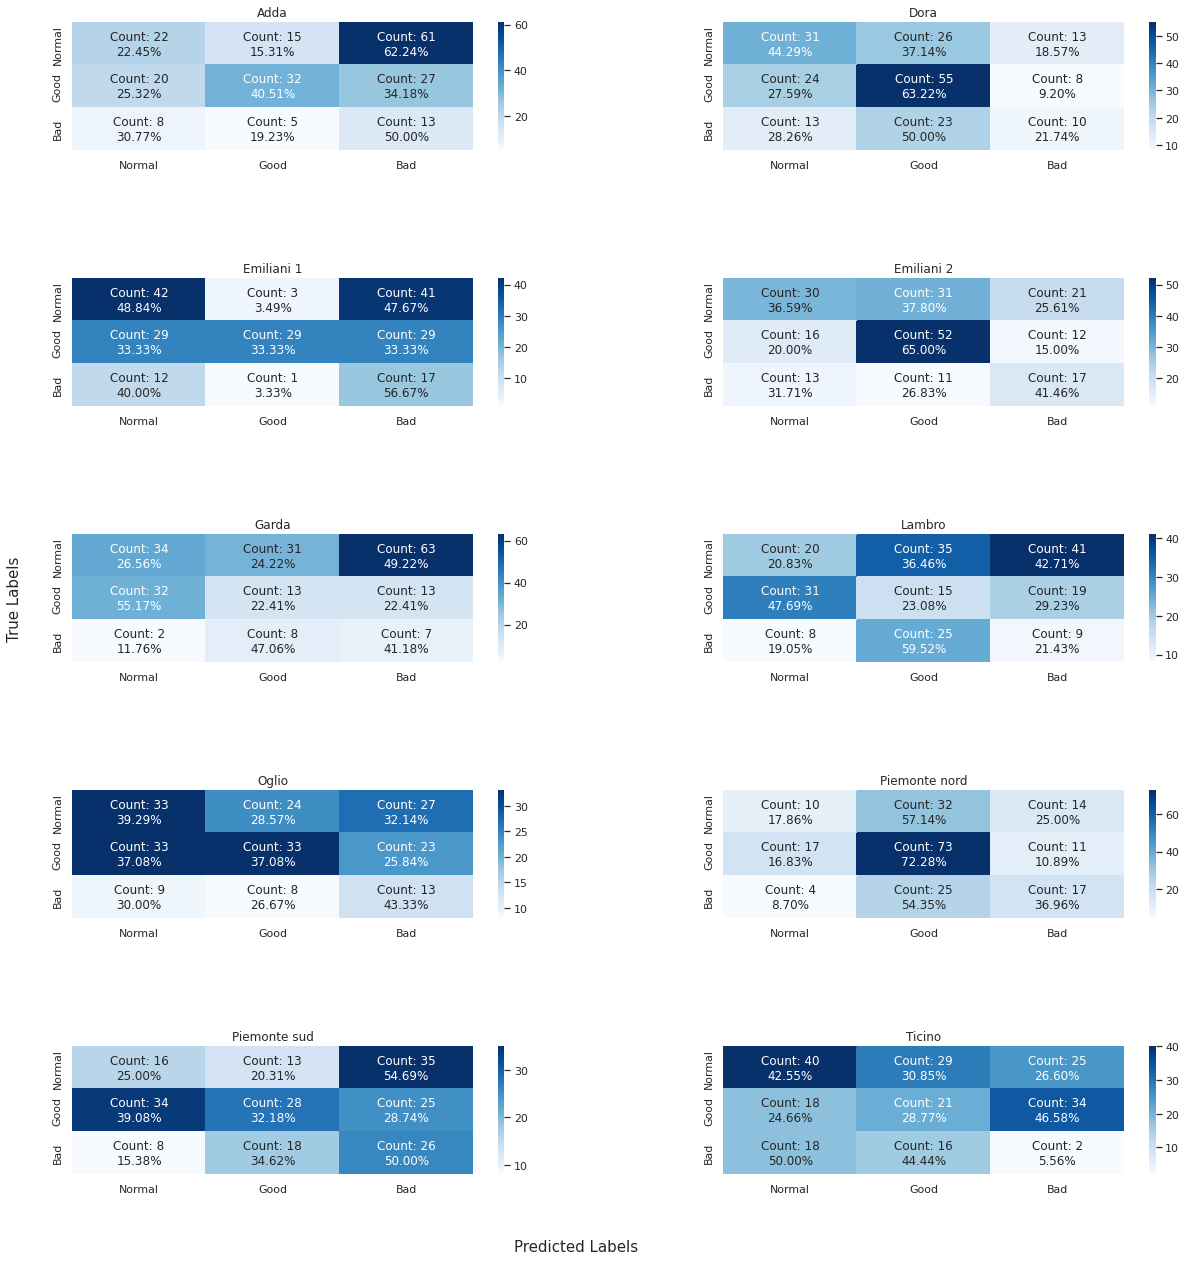

In [49]:
fig, ax = plt.subplots(5,2, figsize=(20,20))
fig.tight_layout()

annot_heatmap(df1, ax=ax[0,0])
ax[0,0].set_title('Adda')
annot_heatmap(df2, ax=ax[0,1])
ax[0,1].set_title('Dora')
annot_heatmap(df3, ax=ax[1,0])
ax[1,0].set_title('Emiliani 1')
annot_heatmap(df4, ax=ax[1,1])
ax[1,1].set_title('Emiliani 2')
annot_heatmap(df5, ax=ax[2,0])
ax[2,0].set_title('Garda')
annot_heatmap(df6, ax=ax[2,1])
ax[2,1].set_title('Lambro')
annot_heatmap(df7, ax=ax[3,0])
ax[3,0].set_title('Oglio')
annot_heatmap(df8, ax=ax[3,1])
ax[3,1].set_title('Piemonte nord')
annot_heatmap(df9, ax=ax[4,0])
ax[4,0].set_title('Piemonte sud')
annot_heatmap(df10, ax=ax[4,1])
ax[4,1].set_title('Ticino')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=1)

# Set common labels

fig.text(0.45, 0.05, 'Predicted Labels', ha='center', va='center', fontsize=15)
fig.text(0.06, 0.5, 'True Labels', ha='center', va='center', rotation='vertical', fontsize=15)

fig.savefig('imgs/multitask_recurrent.eps', format='eps')


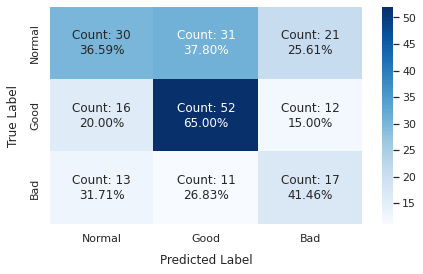

In [50]:
fig, ax = plt.subplots(figsize=(7,4))
annot_heatmap(df4, ax=ax)
ax.set_xlabel('Predicted Label', labelpad=10)
ax.set_ylabel('True Label', labelpad=10)
fig.savefig('imgs/multi_emi2_recurrent.eps', format='eps', bbox_inches='tight')

In [51]:
test_correct = list(map(lambda x: -1 if x==2 else 1 if x==1 else 0, y_test[:, 3]))
pred_correct = list(map(lambda x: -1 if x==2 else 1 if x==1 else 0, predictions[3].argmax(axis=1)))

In [52]:
sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid", {'axes.grid':False})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


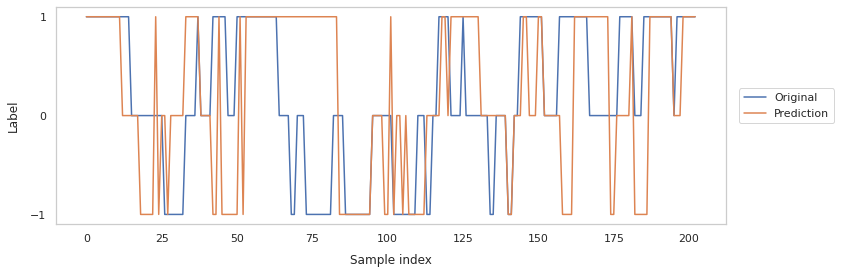

In [53]:
ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))


plt.plot(test_correct, label='Original')
plt.plot(pred_correct, label='Prediction')
plt.legend(loc='upper right', bbox_to_anchor=(1.17,0.65))
plt.xlabel('Sample index',labelpad=10)
plt.ylabel('Label', labelpad=10)
plt.savefig('imgs/curves_emi2_recurrent.eps', format='eps', bbox_inches='tight')

# Task clustering RNN

In [100]:
X_train = train.iloc[:, :120].values
X_validation = validation.iloc[:, :120].values
X_test = test.iloc[:, :120].values

y_train = train.iloc[:, 130:].values
y_validation = validation.iloc[:, 130:].values
y_test = test.iloc[:, 130:].values

In [101]:
input_ = tf.keras.layers.Input(shape=(None, 120), name='input', batch_size=None)

rnn_1 = tf.keras.layers.SimpleRNN(10, name='rnn_1', return_sequences=True)(input_)

dense_1 = tf.keras.layers.Dense(64, name='dense_1', activation='relu')(rnn_1)
dense_2 = tf.keras.layers.Dense(64, name='dense_2', activation='relu')(rnn_1)
dense_3 = tf.keras.layers.Dense(64, name='dense_3', activation='relu')(rnn_1)
dense_4 = tf.keras.layers.Dense(64, name='dense_4', activation='relu')(rnn_1)

out_1 = tf.keras.layers.Dense(3, activation='softmax', name='out_1')(dense_1)
out_2 = tf.keras.layers.Dense(3, activation='softmax', name='out_2')(dense_2)
out_3 = tf.keras.layers.Dense(3, activation='softmax', name='out_3')(dense_3)
out_4 = tf.keras.layers.Dense(3, activation='softmax', name='out_4')(dense_3)
out_5 = tf.keras.layers.Dense(3, activation='softmax', name='out_5')(dense_4)
out_6 = tf.keras.layers.Dense(3, activation='softmax', name='out_6')(dense_1)
out_7 = tf.keras.layers.Dense(3, activation='softmax', name='out_7')(dense_4)
out_8 = tf.keras.layers.Dense(3, activation='softmax', name='out_8')(dense_2)
out_9 = tf.keras.layers.Dense(3, activation='softmax', name='out_9')(dense_3)
out_10 = tf.keras.layers.Dense(3, activation='softmax', name='out_10')(dense_1)

model = tf.keras.models.Model(input_, [out_1, out_2, out_3, out_4, out_5 , out_6, out_7, out_8, out_9, out_10])

model.compile(loss={
    'out_1' : 'sparse_categorical_crossentropy',
    'out_2' : 'sparse_categorical_crossentropy',
    'out_3' : 'sparse_categorical_crossentropy',
    'out_4' : 'sparse_categorical_crossentropy',
    'out_5' : 'sparse_categorical_crossentropy',
    'out_6' : 'sparse_categorical_crossentropy',
    'out_7' : 'sparse_categorical_crossentropy',
    'out_8' : 'sparse_categorical_crossentropy',
    'out_9' : 'sparse_categorical_crossentropy',
    'out_10' : 'sparse_categorical_crossentropy'
}, optimizer='adam', metrics=['accuracy'])

In [102]:
outputs_train = [y_train[:,0].reshape(1,-1),
                 y_train[:, 1].reshape(1,-1),
                 y_train[:, 2].reshape(1,-1),
                 y_train[:, 3].reshape(1,-1),
                 y_train[:, 4].reshape(1,-1),
                 y_train[:, 5].reshape(1,-1),
                 y_train[:, 6].reshape(1,-1),
                 y_train[:, 7].reshape(1,-1),
                 y_train[:, 8].reshape(1,-1),
                 y_train[:, 9].reshape(1,-1)]

outputs_validation = [y_validation[:,0].reshape(1,-1),
                      y_validation[:, 1].reshape(1,-1),
                      y_validation[:, 2].reshape(1,-1),
                      y_validation[:, 3].reshape(1,-1),
                      y_validation[:, 4].reshape(1,-1),
                      y_validation[:, 5].reshape(1,-1),
                      y_validation[:, 6].reshape(1,-1),
                      y_validation[:, 7].reshape(1,-1),
                      y_validation[:, 8].reshape(1,-1),
                      y_validation[:, 9].reshape(1,-1)]

In [103]:
model.fit(X_train.reshape(1,607,120), outputs_train, shuffle=False, validation_data=(X_validation.reshape(1,203,120), outputs_validation), verbose=0, epochs=35, batch_size=32)

In [104]:
train_val = pd.concat([train,validation])

new_outputs_train = [train_val.iloc[int(len(train_val)*0.2):, 130].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 131].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 132].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 133].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 134].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 135].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 136].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 137].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 138].values.reshape(1,-1),
                 train_val.iloc[int(len(train_val)*0.2):, 139].values.reshape(1,-1)]

new_X_train = train_val.iloc[int(len(train_val)*0.2):, :120].values

model.fit(new_X_train.reshape(1,648,120), new_outputs_train, shuffle=False, verbose=0, epochs=35, batch_size=32)

predictions = np.asarray(model.predict(X_test.reshape(1,203,120))).reshape(10,203,3)

In [105]:
acc_1 = accuracy_score(y_test[:, 0], predictions[0, :].argmax(axis=1))
acc_2 = accuracy_score(y_test[:, 1], predictions[1, :].argmax(axis=1))
acc_3 = accuracy_score(y_test[:, 2], predictions[2, :].argmax(axis=1))
acc_4 = accuracy_score(y_test[:, 3], predictions[3, :].argmax(axis=1))
acc_5 = accuracy_score(y_test[:, 4], predictions[4, :].argmax(axis=1))
acc_6 = accuracy_score(y_test[:, 5], predictions[5, :].argmax(axis=1))
acc_7 = accuracy_score(y_test[:, 6], predictions[6, :].argmax(axis=1))
acc_8 = accuracy_score(y_test[:, 7], predictions[7, :].argmax(axis=1))
acc_9 = accuracy_score(y_test[:, 8], predictions[8, :].argmax(axis=1))
acc_10 = accuracy_score(y_test[:, 9], predictions[9, :].argmax(axis=1))

np.mean([acc_1,acc_2,acc_3,acc_4,acc_5,acc_6,acc_7,acc_8,acc_9,acc_10])

0.4684729064039409

In [106]:
acc_4

0.4433497536945813

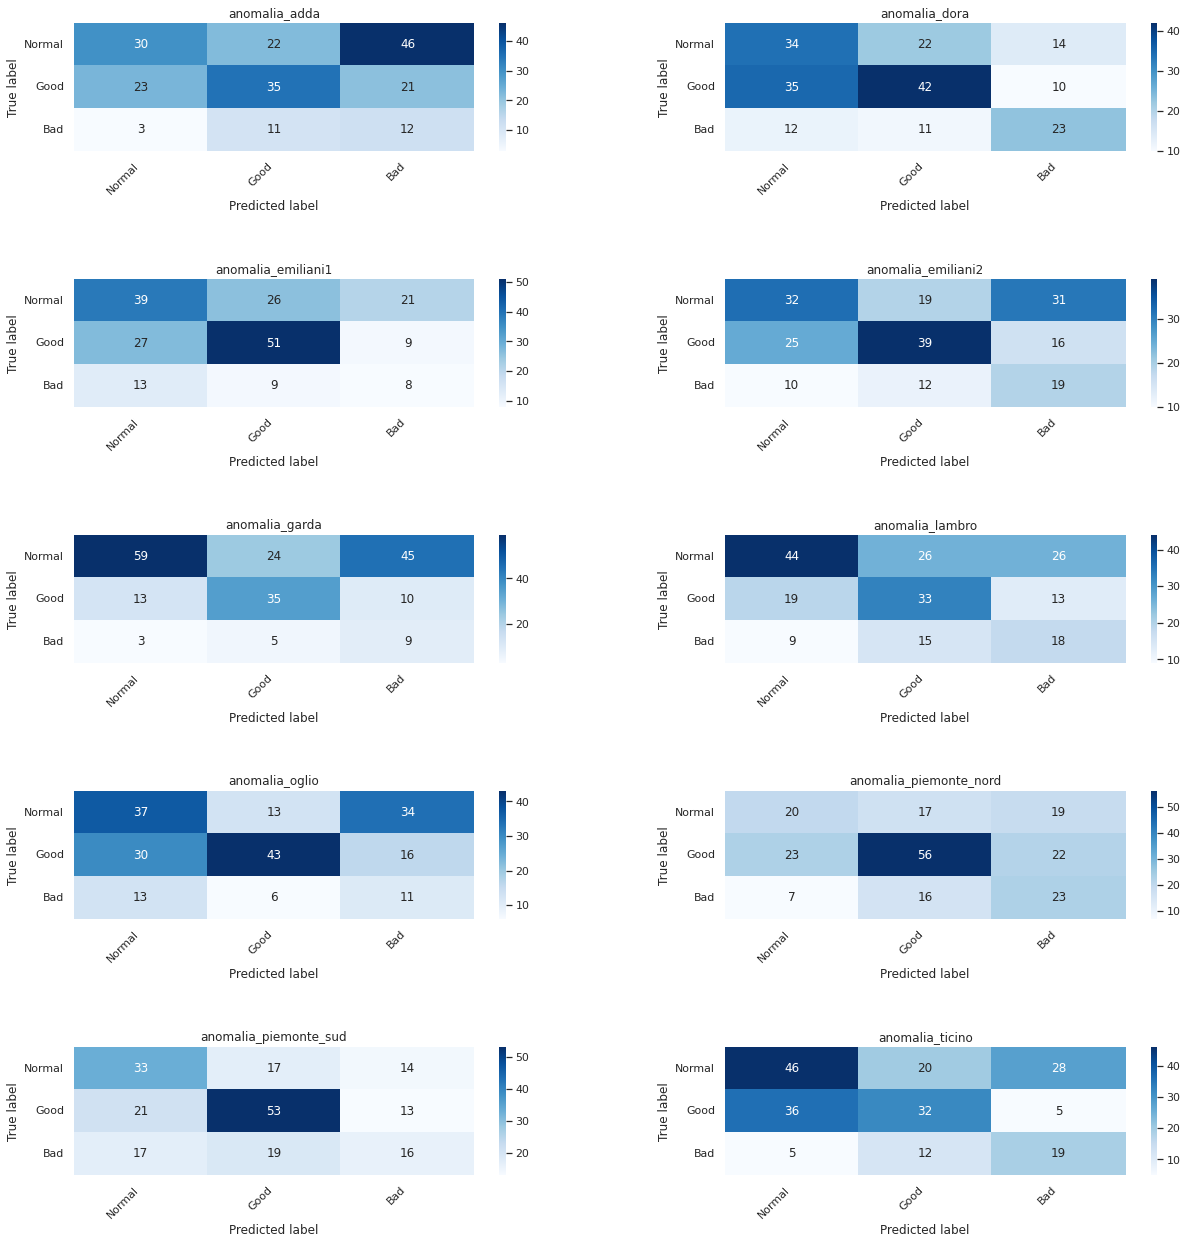

In [107]:
fig, ax = plt.subplots(5,2, figsize=(20,20))
fig.tight_layout()

df1 = plot_conmat(y_test[:, 0], predictions[0].argmax(axis=1), ax=ax[0,0], title=cols[0], return_df=True)
df2 = plot_conmat(y_test[:, 1], predictions[1].argmax(axis=1), ax=ax[0,1], title=cols[1], return_df=True)
df3 = plot_conmat(y_test[:, 2], predictions[2].argmax(axis=1), ax=ax[1,0], title=cols[2], return_df=True)
df4 = plot_conmat(y_test[:, 3], predictions[3].argmax(axis=1), ax=ax[1,1], title=cols[3], return_df=True)
df5 = plot_conmat(y_test[:, 4], predictions[4].argmax(axis=1), ax=ax[2,0], title=cols[4], return_df=True)
df6 = plot_conmat(y_test[:, 5], predictions[5].argmax(axis=1), ax=ax[2,1], title=cols[5], return_df=True)
df7 = plot_conmat(y_test[:, 6], predictions[6].argmax(axis=1), ax=ax[3,0], title=cols[6], return_df=True)
df8 = plot_conmat(y_test[:, 7], predictions[7].argmax(axis=1), ax=ax[3,1], title=cols[7], return_df=True)
df9 = plot_conmat(y_test[:, 8], predictions[8].argmax(axis=1), ax=ax[4,0], title=cols[8], return_df=True)
df10 = plot_conmat(y_test[:, 9], predictions[9].argmax(axis=1), ax=ax[4,1], title=cols[9], return_df=True)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=1)

plt.show()


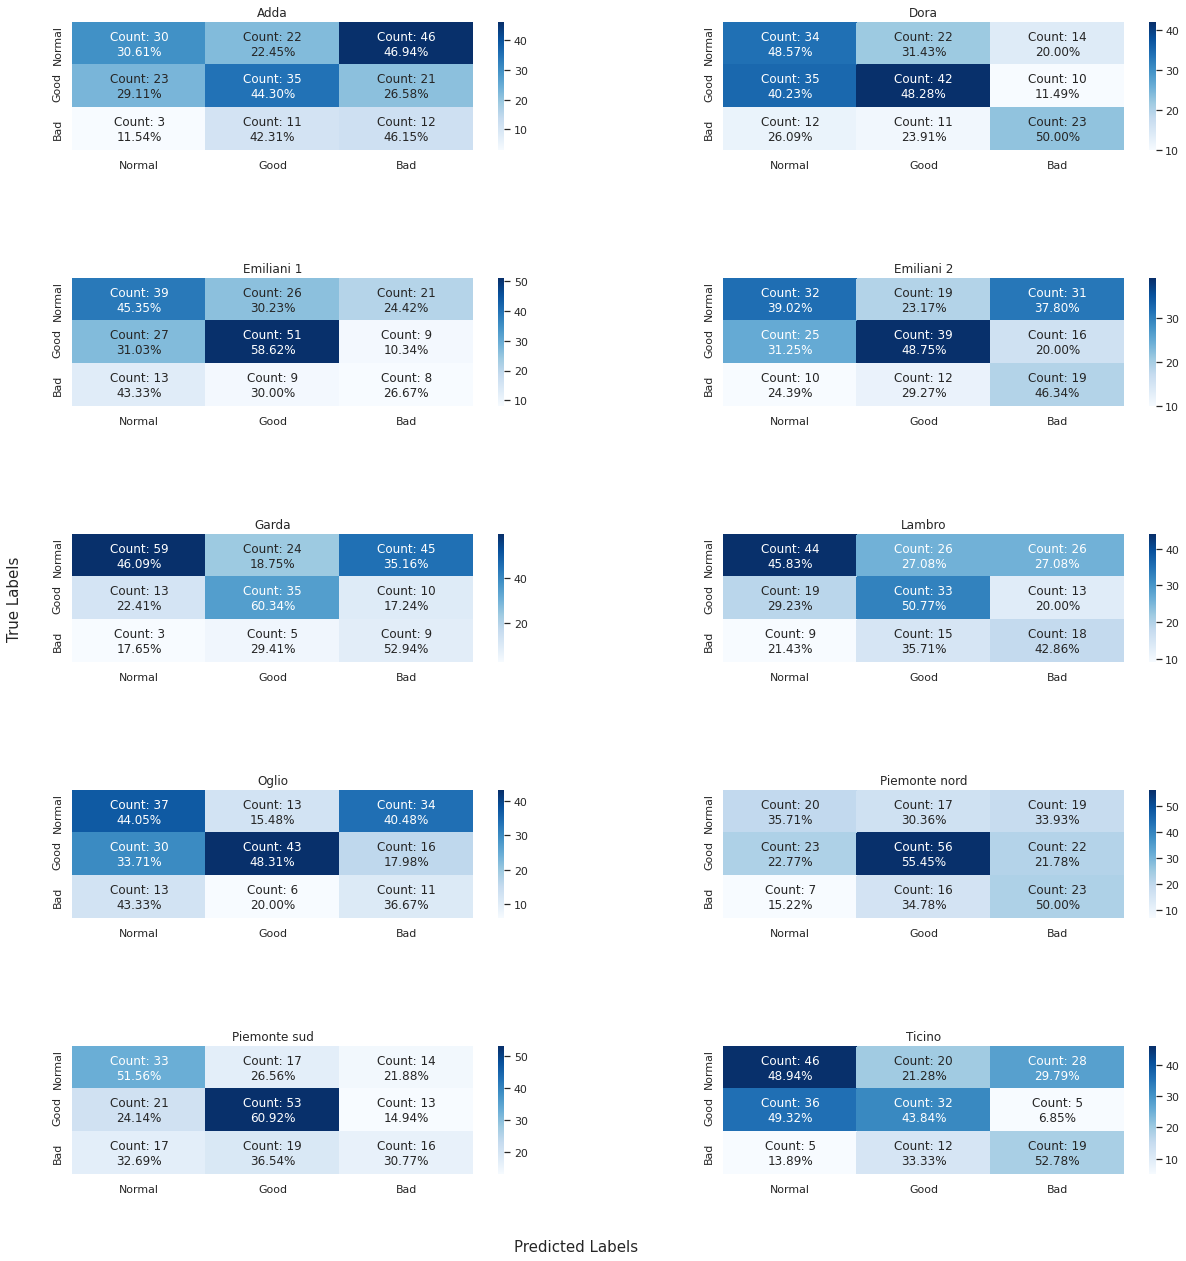

In [108]:
fig, ax = plt.subplots(5,2, figsize=(20,20))
fig.tight_layout()

annot_heatmap(df1, ax=ax[0,0])
ax[0,0].set_title('Adda')
annot_heatmap(df2, ax=ax[0,1])
ax[0,1].set_title('Dora')
annot_heatmap(df3, ax=ax[1,0])
ax[1,0].set_title('Emiliani 1')
annot_heatmap(df4, ax=ax[1,1])
ax[1,1].set_title('Emiliani 2')
annot_heatmap(df5, ax=ax[2,0])
ax[2,0].set_title('Garda')
annot_heatmap(df6, ax=ax[2,1])
ax[2,1].set_title('Lambro')
annot_heatmap(df7, ax=ax[3,0])
ax[3,0].set_title('Oglio')
annot_heatmap(df8, ax=ax[3,1])
ax[3,1].set_title('Piemonte nord')
annot_heatmap(df9, ax=ax[4,0])
ax[4,0].set_title('Piemonte sud')
annot_heatmap(df10, ax=ax[4,1])
ax[4,1].set_title('Ticino')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=1)

# Set common labels

fig.text(0.45, 0.05, 'Predicted Labels', ha='center', va='center', fontsize=15)
fig.text(0.06, 0.5, 'True Labels', ha='center', va='center', rotation='vertical', fontsize=15)

fig.savefig('imgs/multitask_taskcluster_recurrent.eps', format='eps')

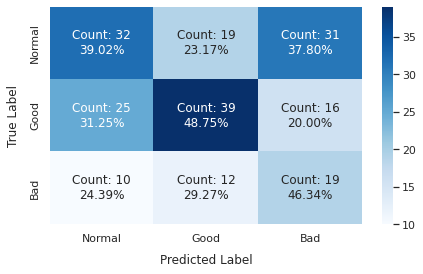

In [109]:
fig, ax = plt.subplots(figsize=(7,4))
annot_heatmap(df4, ax=ax)
ax.set_xlabel('Predicted Label', labelpad=10)
ax.set_ylabel('True Label', labelpad=10)
fig.savefig('imgs/multi_taskcluster_emi2_recurremt.eps', format='eps', bbox_inches='tight')

In [110]:
test_correct = list(map(lambda x: -1 if x==2 else 1 if x==1 else 0, y_test[:, 3]))
pred_correct = list(map(lambda x: -1 if x==2 else 1 if x==1 else 0, predictions[3].argmax(axis=1)))

In [111]:
sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid", {'axes.grid':False})

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


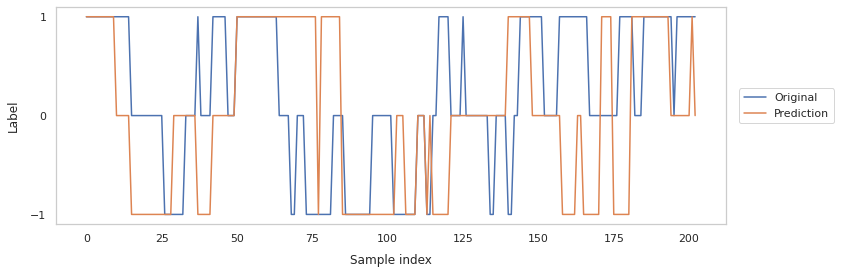

In [112]:
ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))



plt.plot(test_correct, label='Original')
plt.plot(pred_correct, label='Prediction')
plt.legend(loc='upper right', bbox_to_anchor=(1.17,0.65))
plt.xlabel('Sample index',labelpad=10)
plt.ylabel('Label', labelpad=10)
plt.savefig('imgs/curves_taskcluster_emi2_recurrent.eps', format='eps', bbox_inches='tight')

In [98]:
import pickle 

with open('preds_st_ffnn.pickle', 'rb') as f: single_preds = pickle.load(f)

Text(0, 0.5, 'Label')

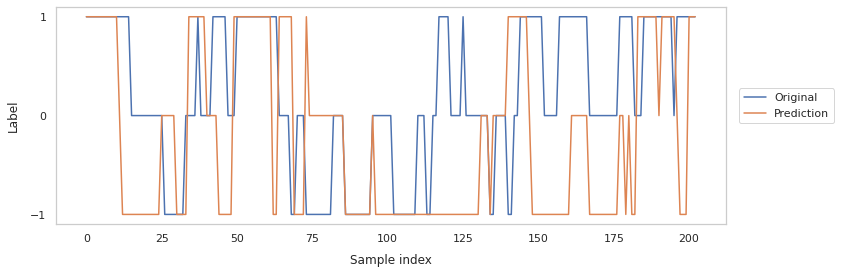

In [99]:
ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))



plt.plot(test_correct, label='Original')
plt.plot(pred_correct, label='Prediction')
plt.legend(loc='upper right', bbox_to_anchor=(1.17,0.65))
plt.xlabel('Sample index',labelpad=10)
plt.ylabel('Label', labelpad=10)